# TICKER TECHNICAL ANALYSIS

<img src="media/bull_bear.jpeg" alt="Alt Text" width="150"/>

Analsys of buy and sell signals for a given ticker price action for the specified date range. The buy and sell 
signals are based on common technical indicators, custom algorythms & compared against Machine Learning models.

### Imported Modules

In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go


### Date Range Ticker


In [2]:
"""
Get current date so we can always get the most recent date from yahoo finance.
date is formated at as YY-mm-dd.

"""


date = datetime.now() + timedelta(days=1)
end_date_fmt = date.strftime("%Y-%m-%d")
start_date = '2021-01-01'
ticker = 'pltr'
istart_date = '2023-01-01'

### Yahoo API Using Date Range and Ticker

In [3]:
df_daily = yf.download(ticker, start = start_date, end = end_date_fmt, progress=False)
df_intra = yf.download(ticker, istart_date, end_date_fmt, progress=False, interval='60m')


In [4]:
"""
The date_range function filters the dataframe for exact date range or span.

"""

def date_range(data, start=None, end=None, span=None):
    if start and end:
        return data[start:end]
    elif span is not None:
        cutoff_date = pd.Timestamp.now()-pd.Timedelta(days=span)
        return data[data.index >= cutoff_date]
    else:
        raise ValueError("Please provide either a date range (start='yyyy-mm-dd', end='yyyy-mm-dd') or span")



### Technical Indicator Functions

EMA

In [5]:
""""
The EMA function calculates the Exponential Moving Average (ema) by finding the average between the fast and slow ema.
The Fastema and Slowema are added as columns to the database.

"""

def ema(dataset, fast, slow, mterm_ema):
   dataset['Fastema'] = dataset['Close'].ewm(span=fast, adjust=False).mean()
   dataset['Slowema'] = dataset['Close'].ewm(span=slow, adjust=False).mean()
   dataset['MidTerm_ema'] = dataset['Close'].ewm(span=mterm_ema, adjust=False).mean()

   return dataset

MACD

In [6]:
"""
The macd1 function is calcuating the Moving Average Convergence Divergence (MACD) by finding the difference between 12 and 26 EMA.
Generate singals based on 9 day moving average.
Inserting a macd histogram that shows macd and signal crossing by finding the difference.
"""


def macd1(dataset):
    dataset['macd12'] =  dataset['Close'].ewm(span=12, adjust=False).mean()
    dataset['macd26'] = dataset['Close'].ewm(span=26, adjust=False).mean()
    dataset['macd'] = dataset['macd12'] - dataset['macd26']
    dataset['signal'] = dataset['macd'].ewm(span=9, adjust=False).mean()
    dataset['macd_hist'] = dataset['macd'] - dataset['signal']

    return dataset





RSI

In [7]:
"""
The RSI function calculates the Relative Strength Index (RSI).
The Median_RSI function calculates overbought_level and oversold_level to find the average.

"""

def rsi(dataset, overbought_level, oversold_level):
    delta = dataset['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    dataset['RSI'] = rsi

    median_rsi = np.median([overbought_level, oversold_level])
    dataset['Median_RSI'] = np.where(rsi > median_rsi, 1, -1)

    return(dataset)


Candle Pattern

In [8]:
'''
The Candle Pattern function is adding the column Candle_Pattern to the dataframe
Candle_Pattern is represented by 0 meaing no change, 1 meaning Close is > the Open, -1 Close < the Open indicating which candle to show.
'''

def candle_pattern(dataset):
    dataset['Candle_Pattern'] = 0
    dataset.loc[dataset['Close'] > dataset['Open'], 'Candle_Pattern'] = 1
    dataset.loc[dataset['Close'] < dataset['Open'], 'Candle_Pattern'] = -1

    return dataset




### Creating Datasets for Calculated And Combined Technical Indicators

In [9]:
# Added a variable called all_indicators that chains/links all technical indicators functions to run all at once.
all_indicators = candle_pattern(rsi(macd1(ema(df_daily,5, 7, 50)),70, 30))

In [10]:
all_indicators_intra = candle_pattern(rsi(macd1(ema(df_intra,5, 7, 50)),70, 30))

In [11]:
# Shows the first 5 rows of all_indicatos dataset.
all_indicators.head()

,Open,High,Low,Close,Adj Close,Volume,Fastema,Slowema,MidTerm_ema,macd12,macd26,macd,signal,macd_hist,RSI,Median_RSI,Candle_Pattern
Date,,,,,,,,,,,,,,,,,
2021-01-04,23.910000,24.500000,22.500000,23.370001,23.370001,44970400,23.370001,23.370001,23.370001,23.370001,23.370001,0.000000,0.000000,0.000000,NaN,-1,-1
2021-01-05,23.180000,24.670000,22.889999,24.600000,24.600000,29050400,23.780001,23.677501,23.418236,23.559232,23.461112,0.098120,0.019624,0.078496,100.000000,1,1
2021-01-06,24.120001,24.459999,23.250000,23.540001,23.540001,32732900,23.700001,23.643126,23.423011,23.556273,23.466956,0.089317,0.033563,0.055755,50.141113,1,-1
2021-01-07,24.020000,25.190001,23.670000,25.000000,25.000000,32240000,24.133334,23.982344,23.484854,23.778385,23.580514,0.197870,0.066424,0.131446,72.182970,1,1
2021-01-08,25.700001,26.440001,24.700001,25.200001,25.200001,41313800,24.488889,24.286758,23.552115,23.997095,23.700476,0.296619,0.112463,0.184156,73.999780,1,-1


In [12]:
all_indicators_intra.head()

,Open,High,Low,Close,Adj Close,Volume,Fastema,Slowema,MidTerm_ema,macd12,macd26,macd,signal,macd_hist,RSI,Median_RSI,Candle_Pattern
Datetime,,,,,,,,,,,,,,,,,
2023-01-03 09:30:00,6.580,6.64,6.290,6.3250,6.3250,7524819,6.325000,6.325000,6.325000,6.325000,6.325000,0.000000,0.000000,0.000000,NaN,-1,-1
2023-01-03 10:30:00,6.325,6.41,6.275,6.3701,6.3701,4999906,6.340033,6.336275,6.326768,6.331938,6.328341,0.003598,0.000720,0.002878,100.000000,1,1
2023-01-03 11:30:00,6.380,6.41,6.340,6.3550,6.3550,3383088,6.345022,6.340956,6.327876,6.335486,6.330315,0.005171,0.001610,0.003561,72.133458,1,-1
2023-01-03 12:30:00,6.355,6.40,6.300,6.3200,6.3200,2859323,6.336681,6.335717,6.327567,6.333104,6.329551,0.003553,0.001998,0.001554,41.330566,-1,-1
2023-01-03 13:30:00,6.320,6.36,6.305,6.3578,6.3578,1738237,6.343721,6.341238,6.328752,6.336903,6.331644,0.005259,0.002651,0.002609,61.707539,1,1


### Algorithm To Determine Bullish And Bearish Trends

In [13]:
# ''''
# The Technical_Algorithm function used to identify bullish and bearish trends in the dataset based on various technical indicators.
# Variables are created to check for bullish and bearish mixtures.
# The dictionary is used to call all mixtures.
# Trends are to anaylize the bullish and bearish mixtures.

# '''

# def technical_algorithm(dataset, bullish_algo_mix, bearish_algo_mix):
#     # This secetion is where I'll define the bullish mixtures.
#     ema_bullish_cross = (dataset['Fastema'] > dataset['Slowema']) & (dataset['Fastema'] < dataset['Slowema']).shift(1)
#     rsi_bullish_check = dataset['Median_RSI'] == 1
#     macd_bullish_cross = dataset['macd12'] > dataset['macd26']
#     macd_bullish_hist = dataset['macd_hist'] > dataset['macd_hist'].shift(1)
#     candle_bullish = dataset.loc[dataset['Close'] > dataset['Open'], 'Candle_Pattern'] == 1
#     ema_bullish_cross2 = (dataset['Fastema'] > dataset['Slowema']) & (dataset['Slowema'] > dataset['MidTerm_ema'])


#     # This secetion is where I'll define the bearish mixtures.
#     ema_bearish_cross = (dataset['Fastema'] < dataset['Slowema']) & (dataset['Fastema'] >= dataset['Slowema']).shift(1)
#     rsi_bearish_check = dataset['Median_RSI'] == -1
#     macd_bearish_cross = dataset['macd12'] < dataset['macd26']
#     macd_bearish_hist =  dataset['macd_hist'] < dataset['macd_hist'].shift(1)
#     candle_bearish = dataset.loc[dataset['Close'] < dataset['Open'], 'Candle_Pattern'] == -1
#     ema_bearish_cross2 = (dataset['Fastema'] < dataset['MidTerm_ema'])


#     # This will be a dictionary of all my mixtures.
#     algo_mix = {
#         'bullish1': ema_bullish_cross,
#         'bearish1': ema_bearish_cross,
#         'bullish2': rsi_bullish_check,
#         'bearish2': rsi_bearish_check,
#         'bullish3': macd_bullish_cross,
#         'bearish3': macd_bearish_cross,
#         'bullish4': macd_bullish_hist,
#         'bearish4': macd_bearish_hist,
#         'bullish5': candle_bullish,
#         'bearish5': candle_bearish,
#         'bullish9': ema_bullish_cross2,
#         'bearish9': ema_bearish_cross2

#     }

#     # Set our Bullish and bearish trends based on mixture.
#     bullish_algo = algo_mix[bullish_algo_mix]
#     bearish_algo = algo_mix[bearish_algo_mix]

#     dataset['Trend'] = 0
#     dataset.loc[bullish_algo, 'Trend'] = 1
#     dataset.loc[bearish_algo, 'Trend'] = -1

#     return dataset

In [14]:
'''
Calculate Trend based on an algorithm using a mix of technical indicators.
'''

def technical_algorithm(dataset, bullish_algo_mix, bearish_algo_mix):
    # Bullish indicators
    rsi_bullish_check = dataset['Median_RSI'] == 1
    ema_bullish_cross = (dataset['Fastema'] > dataset['Slowema']) & (dataset['Fastema'].shift(1) < dataset['Slowema'].shift(1))
    macd_bullish_cross = (dataset['macd'].shift(1) <= dataset['signal'].shift(1))
    macd_bullish_direction = dataset['macd_hist'] > dataset['macd_hist'].shift(1)
    candle_bullish = dataset['Close'] > dataset['Open']
    ema_bullish_cross2 = (dataset['Fastema'] > dataset['Slowema']) & (dataset['Slowema'] > dataset['MidTerm_ema'])

    # Bearish indicators
    rsi_bearish_check = dataset['Median_RSI'] == -1
    ema_bearish_cross = (dataset['Fastema'] < dataset['Slowema']) & (dataset['Fastema'].shift(1) > dataset['Slowema'].shift(1))
    macd_bearish_direction = dataset['macd_hist'] <= dataset['macd_hist'].shift(1)
    candle_bearish = dataset['Close'] <= dataset['Open']
    ema_bearish_cross2 = dataset['Fastema'] < dataset['MidTerm_ema']


    # Dictionary to store my indicator combinations so we can easily set our algos against
    algo_mix = {
        'bullish1': macd_bullish_direction & candle_bullish,
        'bearish1': macd_bearish_direction & candle_bearish,
        'bullish2': macd_bullish_direction & candle_bullish & rsi_bullish_check,
        'bearish2': macd_bearish_direction & candle_bearish & rsi_bearish_check,
        'bullish3': ema_bullish_cross,
        'bearish3': ema_bearish_cross,
        'bullish4': ema_bullish_cross & macd_bullish_direction,
        'bearish4': ema_bearish_cross & macd_bearish_direction,
        'bullish5': ema_bullish_cross & macd_bullish_direction & candle_bullish & rsi_bullish_check,
        'bearish5': ema_bearish_cross & macd_bearish_direction & candle_bearish & rsi_bearish_check,
        'bullish6': ema_bullish_cross & rsi_bullish_check,
        'bearish6': ema_bearish_cross & rsi_bearish_check,
        'bullish7': ema_bullish_cross & macd_bullish_direction & candle_bullish,
        'bearish7': ema_bearish_cross & macd_bearish_direction & candle_bearish,
        'bullish8': ema_bullish_cross2,
        'bearish8': ema_bearish_cross2,
        'bullish9': macd_bullish_direction & candle_bullish & rsi_bullish_check & ema_bullish_cross2,
        'bearish9': macd_bearish_direction & candle_bearish & rsi_bearish_check & ema_bearish_cross2
    }

    # This sets our TREND.
    bullish_algo = algo_mix[bullish_algo_mix]
    bearish_algo = algo_mix[bearish_algo_mix]

    # # Add candle bullish and bearish featurs to datasets
    # dataset.loc[candle_bullish, 'Candle_Pattern'] = 1
    # dataset.loc[candle_bearish, 'Candle_Pattern'] = -1

    # Set default Trend to neutral where we don't get a bullish or bearish Trend
    dataset['Trend'] = 0  # Default value

    # Add Bullish and Bearish Trend Feature to Datasets using result of Algorythm
    dataset.loc[bullish_algo, 'Trend'] = 1
    dataset.loc[bearish_algo, 'Trend'] = -1

    return dataset

In [15]:
intra_techIn = technical_algorithm(all_indicators_intra, 'bullish1', 'bearish1')


In [16]:
def portfolio_performance(dataset, target_feature):
    # Get the first row where the trend is bullish.

    # transaction_daily database is copied and then adding the Bull_Bear column into databse.
    transaction_daily = dataset.copy()
    transaction_daily['Bull_Bear'] = ''

    # Check if there any bullish rows before access the first one
    bullish_rows = dataset[dataset[target_feature] == 1]
    if bullish_rows.empty:
        raise ValueError("No bullish rows found so cannot calculate initial investment")

    first_bullish_row = dataset[dataset[target_feature] == 1].iloc[0]
    initial_investment = first_bullish_row['Close']

    # cash = 0: Sets the initial cash balance to zero
    # Adds a "Cash" column to transaction_daily.
    cash = 0
    transaction_daily['Cash'] = 0

    previous_trend = False

    # This code iterates over each row in transaction_daily to simulate buy and sell actions based on the target_feature signals.
    # This approach updates the cash balance and records buy/sell signals, switching trends only when new signals appear.
    for index, row in transaction_daily.iterrows():
        if row[target_feature] == 1 and previous_trend == False:
            transaction_daily.loc[index, "Bull_Bear"] = 'buy'
            cash -= row['Close']
            transaction_daily.loc[index, 'Cash'] = cash
            previous_trend = True
        elif row[target_feature] == -1 and previous_trend == True:
            transaction_daily.loc[index, "Bull_Bear"] = 'sell'
            cash += row['Close']
            transaction_daily.loc[index, 'Cash'] = cash
            previous_trend = False
        else:
            pass

    # After loop check last row for a sell.
    last_row = transaction_daily.iloc[-1]
    if previous_trend == True:
        transaction_daily.loc[transaction_daily.index[-1], "Bull_Bear"] = 'last_price'
        cash += last_row['Close']
        previous_trend = False


    return transaction_daily, cash, initial_investment







In [17]:
def portfolio_performance(dataset, target_feature):
    # Get the first row where the trend is bullish.

    # transaction_daily database is copied and then adding the Bull_Bear column into databse.
    all_indicators_intra = dataset.copy()
    all_indicators_intra['Bull_Bear'] = ''

    # Check if there any bullish rows before access the first one
    bullish_rows = dataset[dataset[target_feature] == 1]
    if bullish_rows.empty:
        raise ValueError("No bullish rows found so cannot calculate initial investment")

    first_bullish_row = dataset[dataset[target_feature] == 1].iloc[0]
    initial_investment = first_bullish_row['Close']

    # cash = 0: Sets the initial cash balance to zero
    # Adds a "Cash" column to transaction_daily.
    cash = 0
    all_indicators_intra['Cash'] = 0

    previous_trend = False

    # This code iterates over each row in transaction_daily to simulate buy and sell actions based on the target_feature signals.
    # This approach updates the cash balance and records buy/sell signals, switching trends only when new signals appear.
    for index, row in all_indicators_intra.iterrows():
        if row[target_feature] == 1 and previous_trend == False:
            all_indicators_intra.loc[index, "Bull_Bear"] = 'buy'
            cash -= row['Close']
            all_indicators_intra.loc[index, 'Cash'] = cash
            previous_trend = True
        elif row[target_feature] == -1 and previous_trend == True:
            all_indicators_intra.loc[index, "Bull_Bear"] = 'sell'
            cash += row['Close']
            all_indicators_intra.loc[index, 'Cash'] = cash
            previous_trend = False
        else:
            pass

    # After loop check last row for a sell.
    last_row = all_indicators_intra.iloc[-1]
    if previous_trend == True:
        all_indicators_intra.loc[all_indicators_intra.index[-1], "Bull_Bear"] = 'last_price'
        cash += last_row['Close']
        previous_trend = False


    return all_indicators_intra, cash, initial_investment

## Candle Stick Visualization Chart

### Daily Visualization And Performance

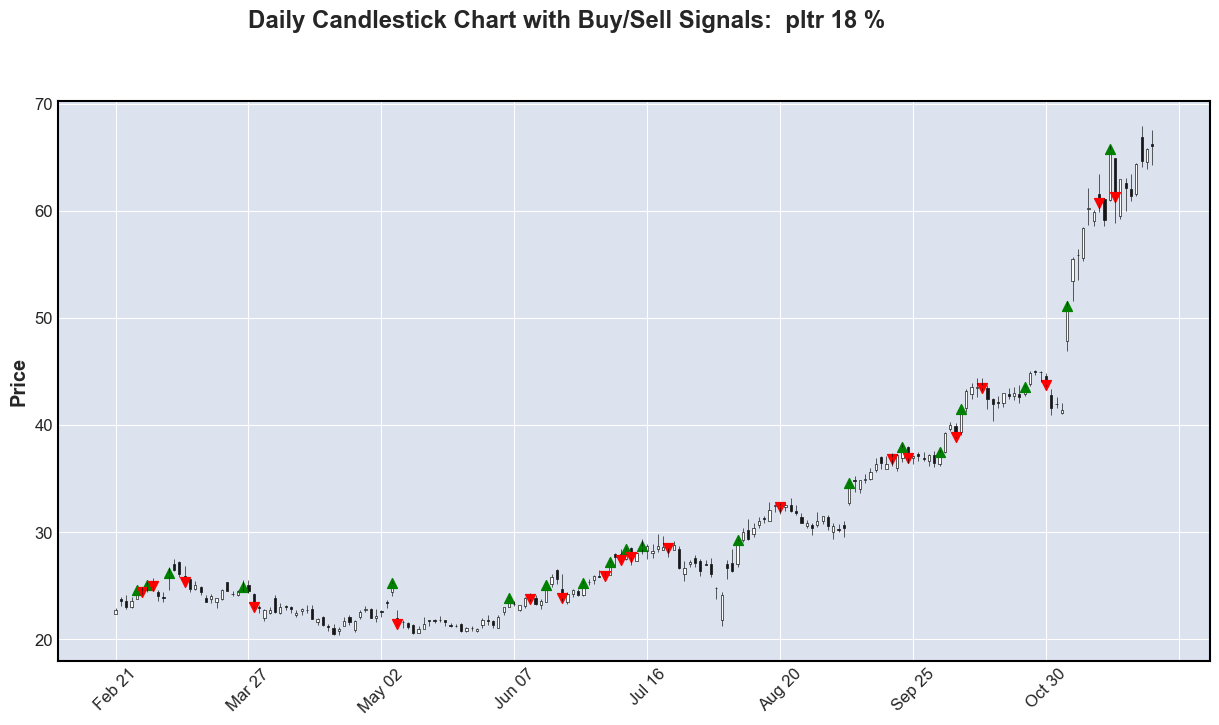

  Initial Investment:    24.530000686645508
       Ending Value:    4.60
Return On Investment:   18 %


,Close,Trend,Bull_Bear,Cash
Date,,,,
2024-02-27,24.530001,1,buy,-24.530001
2024-02-28,24.420000,-1,sell,-0.110001
2024-02-29,25.080000,1,buy,-25.190001
2024-03-01,24.930000,-1,sell,-0.260000
2024-03-06,26.160000,1,buy,-26.420000
2024-03-11,25.350000,-1,sell,-1.070000
2024-03-26,24.889999,1,buy,-25.959999
2024-03-28,23.010000,-1,sell,-2.949999
2024-05-06,25.209999,1,buy,-28.159998


In [18]:
'''
The code runs a technical alogrithm function that generates trading signals with database all_indicators, based on bullish/bearish conditions.
Filters these signals to a 60-day range using date_range.
Displays the first 50 transactions in transaction_daily.
ROI calculates the return on investment as a percentage.
mpf.plots puts the database into candle stick chart showing the buy (green) and sell (red) signal.

'''

techn_algo = technical_algorithm(all_indicators, 'bullish9', 'bearish1')
filter_range = date_range(techn_algo, span=282)
transaction_daily, cash, initial_investment = portfolio_performance(filter_range, 'Trend')
transaction_daily.head(50)

roi = int((cash / initial_investment) * 100)


mpf.plot(
    transaction_daily,
    type='candle',
    title=f'Daily Candlestick Chart with Buy/Sell Signals:  {ticker} {roi} % ',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(transaction_daily['Bull_Bear'] == 'buy', transaction_daily['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='green'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(transaction_daily['Bull_Bear'] == 'sell', transaction_daily['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


print('  Initial Investment:   ',initial_investment)
print(f'       Ending Value:    {cash:.2f}')
print('Return On Investment:  ', roi, '%')

transaction_daily = pd.DataFrame(transaction_daily, columns=['Close', 'Trend', 'Bull_Bear', 'Cash'])
transaction_daily[transaction_daily['Bull_Bear'] != '']

### Intra Day Visualization And Performance

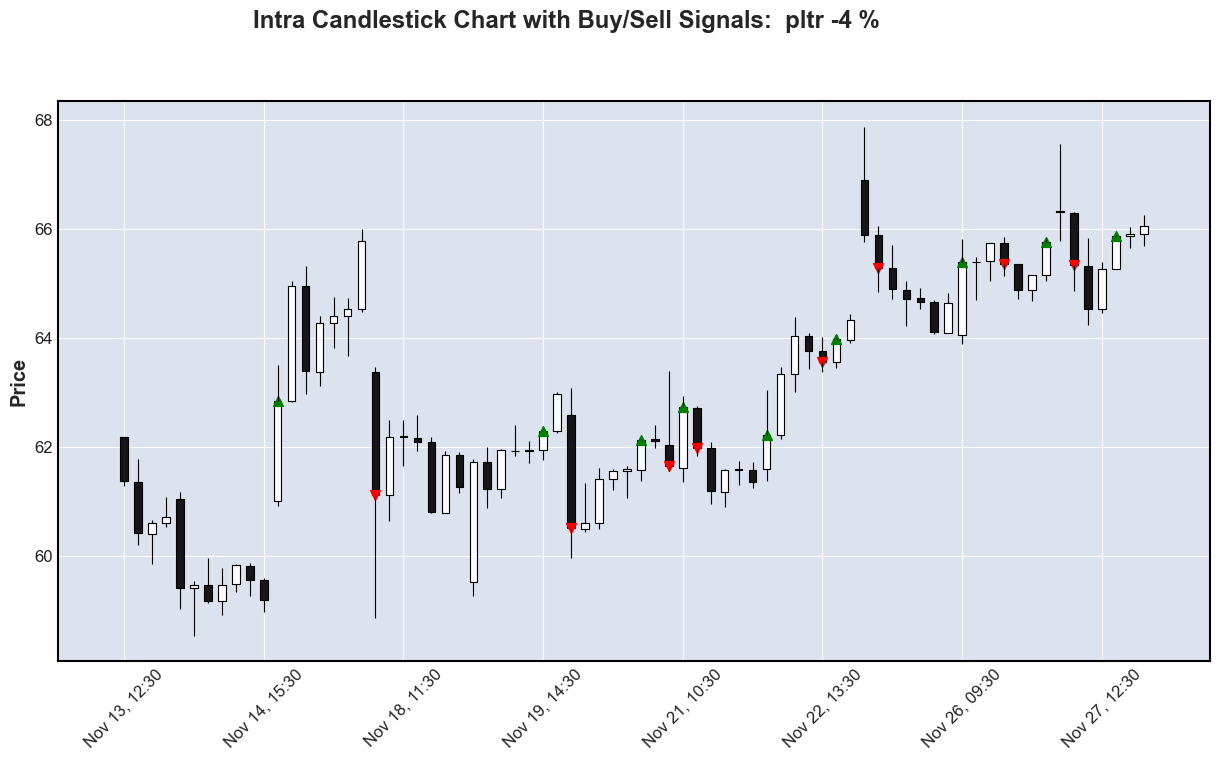

  Initial Investment:    62.85
       Net Gain/Loss:    -2.38
Return On Investment:    -4 %


,Close,Trend,Bull_Bear,Cash
Datetime,,,,
2024-11-15 09:30:00,62.846401,1,buy,-62.846401
2024-11-18 09:30:00,61.111500,-1,sell,-1.734901
2024-11-19 14:30:00,62.292400,1,buy,-64.027302
2024-11-20 09:30:00,60.505001,-1,sell,-3.522301
2024-11-20 14:30:00,62.130100,1,buy,-65.652401
2024-11-21 09:30:00,61.639999,-1,sell,-4.012402
2024-11-21 10:30:00,62.723202,1,buy,-66.735603
2024-11-21 11:30:00,61.985001,-1,sell,-4.750603
2024-11-22 09:30:00,62.209999,1,buy,-66.960602


In [19]:

techn_algo = technical_algorithm(all_indicators_intra, 'bullish9', 'bearish1')
# filter_range = date_range(techn_algo, start='2024-10-01',end=end_date_fmt)
filter_range = date_range(techn_algo, span=15)
all_indicators_intra, icash, iinitial_investment = portfolio_performance(filter_range, 'Trend')
all_indicators_intra.head(50)

iroi = ((icash / iinitial_investment) * 100)


mpf.plot(
    all_indicators_intra,
    type='candle',
    title=f'Intra Candlestick Chart with Buy/Sell Signals:  {ticker} {round(iroi)} % ',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(all_indicators_intra['Bull_Bear'] == 'buy', all_indicators_intra['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='green'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(all_indicators_intra['Bull_Bear'] == 'sell', all_indicators_intra['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


print(f'  Initial Investment:    {iinitial_investment:.2f}')
print(f'       Net Gain/Loss:    {icash:.2f}')
print(f'Return On Investment:    {round(iroi)} %')

all_indicators_intra_trans = pd.DataFrame(all_indicators_intra, columns=['Close', 'Trend', 'Bull_Bear', 'Cash'])
all_indicators_intra_trans[all_indicators_intra_trans['Bull_Bear'] != '']

In [20]:
# transaction_daily fitlers throuhg only the Bull_Bear Column where they are empty.
# transaction_daily[transaction_daily['Bull_Bear'] != '']
all_indicators_intra[all_indicators_intra['Bull_Bear'] != '']



,Open,High,Low,Close,Adj Close,Volume,Fastema,Slowema,MidTerm_ema,macd12,macd26,macd,signal,macd_hist,RSI,Median_RSI,Candle_Pattern,Trend,Bull_Bear,Cash
Datetime,,,,,,,,,,,,,,,,,,,,
2024-11-15 09:30:00,61.009998,63.500000,60.910000,62.846401,62.846401,43869465,60.623741,60.437783,57.485134,60.305894,59.695990,0.609904,0.773079,-0.163175,72.455326,1,1,1,buy,-62.846401
2024-11-18 09:30:00,63.380001,63.459999,58.849998,61.111500,61.111500,66162482,63.373206,63.281883,59.082728,62.771650,61.483437,1.288213,1.202637,0.085576,41.982845,-1,-1,-1,sell,-1.734901
2024-11-19 14:30:00,61.935001,62.299999,61.764999,62.292400,62.292400,4235078,61.974078,61.943574,60.114438,61.961183,61.673295,0.287888,0.452133,-0.164245,54.237554,1,1,1,buy,-64.027302
2024-11-20 09:30:00,62.590000,63.080002,59.959999,60.505001,60.505001,22307274,61.706813,61.777323,60.237534,61.869131,61.676035,0.193096,0.383574,-0.190478,37.734267,-1,-1,-1,sell,-3.522301
2024-11-20 14:30:00,61.580002,62.147900,61.369999,62.130100,62.130100,4990524,61.698718,61.668560,60.463616,61.696442,61.622414,0.074028,0.163053,-0.089025,55.448149,1,1,1,buy,-65.652401
2024-11-21 09:30:00,62.040001,63.400002,61.549999,61.639999,61.639999,20509211,61.770563,61.744208,60.571784,61.741607,61.657166,0.084442,0.137489,-0.053047,48.358042,-1,-1,-1,sell,-4.012402
2024-11-21 10:30:00,61.610001,62.939999,61.360001,62.723202,62.723202,8661118,62.088109,61.988957,60.656153,61.892622,61.736131,0.156491,0.141289,0.015201,61.109301,1,1,1,buy,-66.735603
2024-11-21 11:30:00,62.720200,62.750000,61.840000,61.985001,61.985001,5477367,62.053740,61.987968,60.708265,61.906834,61.754566,0.152268,0.143485,0.008783,51.173392,1,-1,-1,sell,-4.750603
2024-11-22 09:30:00,61.599998,63.040001,61.369999,62.209999,62.209999,15777196,61.775312,61.759974,60.869139,61.757607,61.708189,0.049418,0.076288,-0.026870,56.493807,1,1,1,buy,-66.960602


# AI Machine Learning Comparison

### Data Cleaning

In [21]:
# Check for nulls, blanks, nan
all_indicators.isnull().sum()
all_indicators_intra.isnull().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Fastema           0
Slowema           0
MidTerm_ema       0
macd12            0
macd26            0
macd              0
signal            0
macd_hist         0
RSI               0
Median_RSI        0
Candle_Pattern    0
Trend             0
Bull_Bear         0
Cash              0
dtype: int64

In [22]:
# Drop Nulls
all_indicators.dropna(inplace=True)
all_indicators_intra.dropna(inplace=True)

###  K-Nearest Neighbors Supervised Machine Learning Algorythm

The Predicted_Trend data is the K-Nearest Neighbors (KNN) Machine Learning algorythm prediction.  The KNN model is trained on the historical data, with the "Trend" feature as the target lable. The Trend feature is the actual trend direction to predict.  During training, the model learns specific feature patterns (the combinations of technical indicators) with different trends.

Making Predictions:
When you provide the model with new data (the test set), it predicts the trend direction based on the nearest neighbors in the feature space. This is stored in y_pred, which then gets assigned to Predicted_Trend.

Understanding Predicted_Trend: 
Each value in Predicted_Trend is the model's prediction of the trend direction, based on the patterns it learned during training. It’s essentially the model’s best guess of whether the trend is likely to be upward, downward, or follow any other trend category you specified.

Evaluating Performance: 
You can compare Predicted_Trend with the actual Trend in the test data to measure the model’s accuracy and understand how well it generalizes to unseen data.

Predicted_Trend is the KNN model’s forecast of future trends based on the features provided.

### Machine Learning Targeting Trend - Daily

In [23]:
# KNN Model
df_knn = all_indicators.copy()

features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Fastema',
       'Slowema', 'MidTerm_ema', 'macd12', 'macd26', 'macd', 'signal',
       'macd_hist', 'RSI', 'Median_RSI', 'Candle_Pattern']

# Set features for trainging and target feature for prediction.
X = df_knn[features]
y = df_knn['Trend']

# Split Data Into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standarized the featured data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Train KNN Model.
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Make Predictions
y_pred = knn.predict(X_test_scaled)

# Evalaute the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Display predicted trend
df_test_knn = df_knn.iloc[len(X_train):].copy()
df_test_knn['Predicted_Trend'] = y_pred

df_test_knn[['Close', 'Trend', 'Predicted_Trend']]

Accuracy: 70.56%


,Close,Trend,Predicted_Trend
Date,,,
2024-02-20,23.400000,-1,-1
2024-02-21,22.740000,0,0
2024-02-22,23.590000,-1,-1
2024-02-23,22.969999,-1,-1
2024-02-26,23.559999,0,0
...,...,...,...
2024-11-21,61.360001,-1,-1
2024-11-22,64.349998,0,1
2024-11-25,64.650002,-1,-1


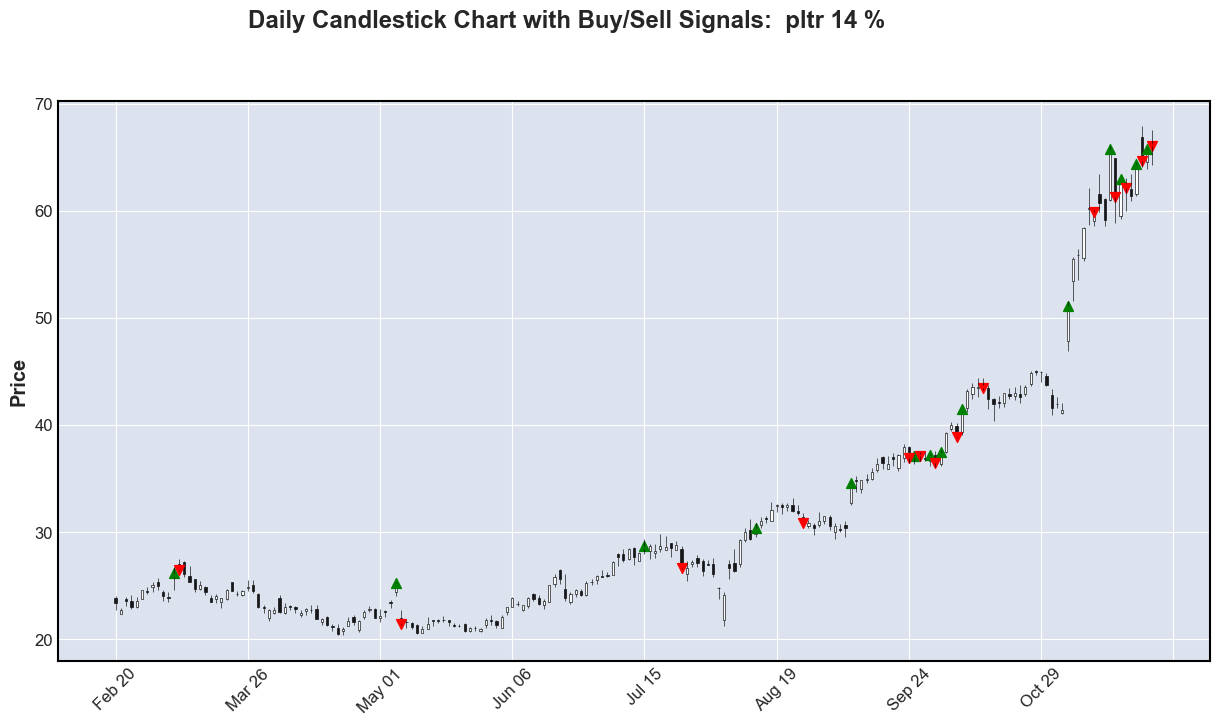

  Initial Investment:    26.15999984741211
       Ending Value:    3.73
Return On Investment:   14 %


,Close,Trend,Bull_Bear,Cash
Date,,,,
2024-03-06,26.160000,1,buy,-26.160000
2024-03-07,26.459999,0,sell,0.299999
2024-05-06,25.209999,1,buy,-24.910000
2024-05-07,21.400000,-1,sell,-3.510000
2024-07-15,28.670000,1,buy,-32.180000
2024-07-24,26.600000,-1,sell,-5.580000
2024-08-13,30.389999,1,buy,-35.969999
2024-08-26,30.850000,-1,sell,-5.119999
2024-09-09,34.599998,1,buy,-39.719997


In [24]:
'''


'''

knn_transaction_daily,knn_cash, knn_initial_investment = portfolio_performance(df_test_knn, 'Predicted_Trend')

knn_roi = int((knn_cash / knn_initial_investment) * 100)


mpf.plot(
    knn_transaction_daily,
    type='candle',
    title=f'Daily Candlestick Chart with Buy/Sell Signals:  {ticker} {knn_roi} % ',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(knn_transaction_daily['Bull_Bear'] == 'buy', knn_transaction_daily['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='green'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(knn_transaction_daily['Bull_Bear'] == 'sell', knn_transaction_daily['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


print('  Initial Investment:   ',knn_initial_investment)
print(f'       Ending Value:    {knn_cash:.2f}')
print('Return On Investment:  ', knn_roi, '%')

knn_transaction_daily = pd.DataFrame(knn_transaction_daily, columns=['Close', 'Trend', 'Bull_Bear', 'Cash'])
knn_transaction_daily[knn_transaction_daily['Bull_Bear'] != '']

### Machine Learning Targeting Trend - Intra Day

In [25]:
# KNN Model
df_knn2 = all_indicators_intra.copy()

features2 = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Fastema',
       'Slowema', 'MidTerm_ema', 'macd12', 'macd26', 'macd', 'signal',
       'macd_hist', 'RSI', 'Median_RSI', 'Candle_Pattern']


# Set features for trainging and target feature for prediction.
X_intra = df_knn2[features2]
y_intra = df_knn2['Trend']


# # Split Data Into Training and Test Sets
X_train_intra, X_test_intra, y_train_intra, y_test_intra = train_test_split(X_intra, y_intra, test_size=0.4, shuffle=False)

# Standardize the featured data
scaler_intra = StandardScaler()
X_train_scaled_intra = scaler_intra.fit_transform(X_train_intra)
X_test_scaled2 = scaler_intra.transform(X_test_intra)  # Use transform, not fit_transform

# Train KNN Model
knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(X_train_scaled_intra, y_train_intra)

# Make Predictions
y_pred2 = knn2.predict(X_test_scaled2)

# Evaluate the Model
accuracy2 = accuracy_score(y_test_intra, y_pred2)
print(f'Accuracy: {accuracy2*100:.2f}%')

# Display predicted trend
df_test_knn_intra = df_knn2.iloc[len(X_train_intra):].copy()  # Ensure the correct DataFrame
df_test_knn_intra['Predicted_Trend'] = y_pred2

print(df_test_knn_intra[['Close', 'Trend', 'Predicted_Trend']])

Accuracy: 53.33%
                         Close  Trend  Predicted_Trend
Datetime                                              
2024-11-21 14:30:00  61.580002     -1               -1
2024-11-21 15:30:00  61.349998     -1               -1
2024-11-22 09:30:00  62.209999      1                1
2024-11-22 10:30:00  63.343800      1                1
2024-11-22 11:30:00  64.042603      1                1
2024-11-22 12:30:00  63.764999      0               -1
2024-11-22 13:30:00  63.555000     -1               -1
2024-11-22 14:30:00  63.974998      1                1
2024-11-22 15:30:00  64.330002      1                1
2024-11-25 09:30:00  65.900002      0                1
2024-11-25 10:30:00  65.286797     -1                1
2024-11-25 11:30:00  64.906898     -1                1
2024-11-25 12:30:00  64.720100     -1                1
2024-11-25 13:30:00  64.660004     -1                1
2024-11-25 14:30:00  64.105003     -1                1
2024-11-25 15:30:00  64.639999      0           

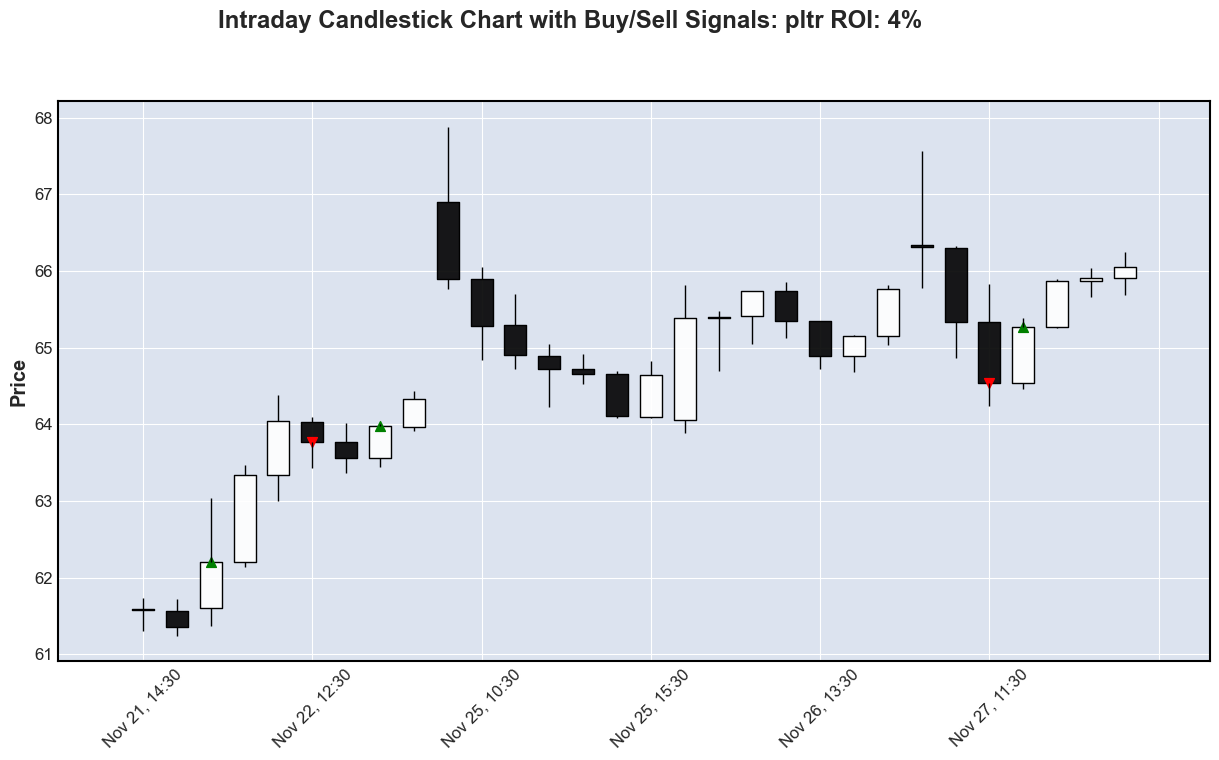

Initial Investment:   62.209999084472656
Ending Value:        2.90
Return on Investment: 4 %


,Close,Trend,Bull_Bear,Cash
Datetime,,,,
2024-11-22 09:30:00,62.209999,1,buy,-62.209999
2024-11-22 12:30:00,63.764999,0,sell,1.555000
2024-11-22 14:30:00,63.974998,1,buy,-62.419998
2024-11-27 11:30:00,64.540001,-1,sell,2.120003
2024-11-27 12:30:00,65.270203,0,buy,-63.150200
2024-11-27 15:30:00,66.050003,1,last_price,0.000000


In [26]:
# Calculate Return on Investment (ROI)
knn_transaction_intra, knn_cash_intra, knn_initial_investment_intra = portfolio_performance(df_test_knn_intra, 'Predicted_Trend')
knn_roi_intra = int((knn_cash_intra / knn_initial_investment_intra) * 100)

# Create candlestick chart with buy/sell signals
mpf.plot(
    knn_transaction_intra,
    type='candle',
    title=f'Intraday Candlestick Chart with Buy/Sell Signals: {ticker} ROI: {knn_roi_intra}%',
    figsize=(16, 8),
    ylabel='Price',
    ylabel_lower='Volume',  # Label for volume subplot
    addplot=[
        mpf.make_addplot(
            np.where(knn_transaction_intra['Bull_Bear'] == 'buy', knn_transaction_intra['Close'], np.nan),
            type='scatter',
            markersize=50,
            marker='^',  # Upward triangle for buy signals
            color='green'
        ),
        mpf.make_addplot(
            np.where(knn_transaction_intra['Bull_Bear'] == 'sell', knn_transaction_intra['Close'], np.nan),
            type='scatter',
            markersize=50,
            marker='v',  # Downward triangle for sell signals
            color='red'
        )
    ],

)

# Display ROI results
print('Initial Investment:  ', knn_initial_investment_intra)
print(f'Ending Value:        {knn_cash_intra:.2f}')
print('Return on Investment:', knn_roi_intra, '%')

knn_transaction_intra_trans = pd.DataFrame(knn_transaction_intra, columns=['Close', 'Trend', 'Bull_Bear', 'Cash'])
knn_transaction_intra_trans[knn_transaction_intra_trans['Bull_Bear'] != '']